# Testing a base model

Currently i've chosen keras, as it would be quick to try things out + exam comming up (using keras) on 13th of January

In [1]:
# %pip install scikit-learn keras 'tensorflow[and-cuda]' opencv-python python-dotenv pandas sqlalchemy PyMySQL matplotlib

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-01-06 02:43:55.669140: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 02:43:55.680659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736127835.693895  149111 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736127835.697562  149111 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 02:43:55.711283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import keras
import numpy as np
import pandas as pd

In [4]:
from FrameLoader import FrameLoader
from DataRepository import DataRepository
from helpers import plot

In [5]:
repo = DataRepository()
repo.load_relativePaths_of_videos_with_framelabels()
repo.VideoNames.head()
# repo.VideoNames.iloc[0]["name"]

connection established


,folderId,id,name
id,,,
651,3,651,competition/belgium/DD3/2023-PK-ZA-10-3DD-Stef...
644,3,644,competition/belgium/DD3/2023-PK-ZO-9.mp4
2,3,2,competition/belgium/DD3/bk-handles-dd3-2024-ju...
5,3,5,competition/belgium/DD3/bk-handles-dd3-2024-se...
581,3,581,competition/belgium/DD3/bk-handles-dd3-2024-se...


In [6]:
frameloader = FrameLoader(repo)

In [7]:
f = frameloader.get_frame(8, 66, 250)
f

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

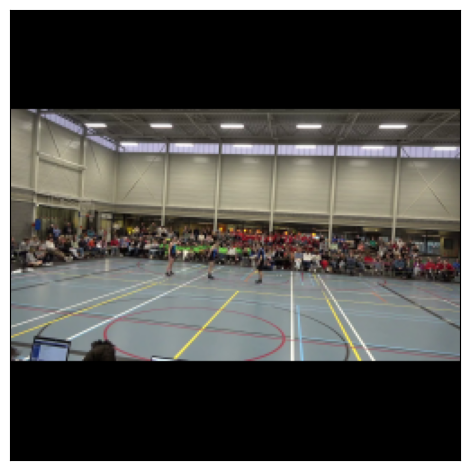

In [8]:
plot([f])

In [9]:
repo.VideoNames.head()

,folderId,id,name
id,,,
651,3,651,competition/belgium/DD3/2023-PK-ZA-10-3DD-Stef...
644,3,644,competition/belgium/DD3/2023-PK-ZO-9.mp4
2,3,2,competition/belgium/DD3/bk-handles-dd3-2024-ju...
5,3,5,competition/belgium/DD3/bk-handles-dd3-2024-se...
581,3,581,competition/belgium/DD3/bk-handles-dd3-2024-se...


In [10]:
repo.VideoNames.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 651 to 142
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   folderId  59 non-null     int64 
 1   id        59 non-null     int64 
 2   name      59 non-null     object
dtypes: int64(2), object(1)
memory usage: 3.9+ KB


In [11]:
repo.VideoNames.loc[581]["name"]

'competition/belgium/DD3/bk-handles-dd3-2024-senioren-mixed-z1.mp4'

In [25]:
class DataGeneratorFrames(keras.utils.Sequence):
    def __init__(self,
                 frameloader,
                 train_test_val: str, # train, test, val
                 dim: tuple, # e.g. (128,128)
                 batch_size=32, # Default batch size
                 **kwargs):
        super().__init__(**kwargs)
        assert isinstance(dim, tuple)
        assert len(dim) == 2
        assert isinstance(train_test_val, str)
        assert train_test_val in ['train', 'test', 'val']
        self.dim = dim
        self.train_test_val = train_test_val
        self.batch_size = batch_size
        self.frameloader = frameloader
        self.repo = DataRepository()
        self.Frames = self.repo.get_framelabels(train_test_val)

        print('DataGeneratorSkillBorders init done')
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        print("len")
        return len(self.Frames) // self.batch_size

    def __getitem__(self, batch_nr):
        "batch_nr starts from 0"
        print("getitem", batch_nr)
        frames = []
        for i in range(batch_nr * self.batch_size, min(len(self.Frames), (batch_nr + 1) * self.batch_size)):
            row = self.Frames.iloc[i]
            frames.append(self.frameloader.get_frame(row["videoId"], row["frameNr"], self.dim[0]))
        return np.array(frames)


    def on_epoch_end(self):
        print('on_epoch_end_called')
        self.Frames = self.Frames.sample(frac=1.)


In [26]:
train_gen = DataGeneratorFrames(
    frameloader=frameloader,
    train_test_val="train",
    dim=(364,364),
    batch_size=8
)

connection established
DataGeneratorSkillBorders init done
on_epoch_end_called


In [28]:
train_gen.__getitem__(5).shape

getitem 5


(8, 364, 364, 3)